Week 5 · Day 6 — Evaluation & Training Loops
Why this matters

Training neural nets is more than calling .backward(). You need structured loops, metrics, validation splits, and tracking to know if your model is learning, overfitting, or failing.

Theory Essentials

Epoch = one full pass through training data.

Mini-batch = small chunk of data (controls gradient updates).

Training loop structure:

Set model.train() → forward → loss → backward → step.

After each epoch, evaluate on model.eval() (no gradient calc).

Validation set helps detect overfitting.

Metrics:

Accuracy (classification).

Precision/recall/F1 (imbalanced).

Confusion matrix (detailed errors).

Always zero out gradients before next step.

Epoch 1: train_loss=0.3656, val_loss=0.2044, val_acc=0.941
Epoch 2: train_loss=0.1579, val_loss=0.1419, val_acc=0.957
Epoch 3: train_loss=0.1096, val_loss=0.1312, val_acc=0.959
Epoch 4: train_loss=0.0824, val_loss=0.1235, val_acc=0.964
Epoch 5: train_loss=0.0648, val_loss=0.1086, val_acc=0.968


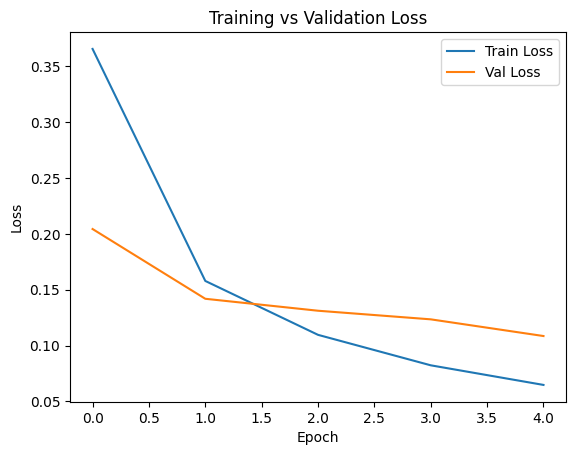

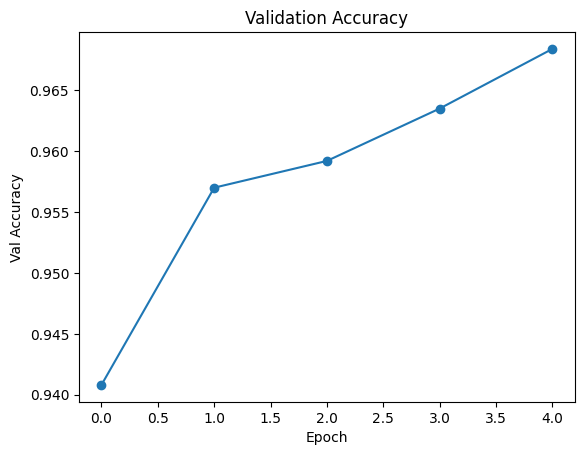

In [7]:
# Setup
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import random_split, DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

torch.manual_seed(42)

# ---------- Data ----------
transform = transforms.Compose([transforms.ToTensor()])
dataset = datasets.MNIST(root="data", train=True, download=True, transform=transform)

# Split into train (50k) + val (10k)
train_data, val_data = random_split(dataset, [50000, 10000])
test_data = datasets.MNIST(root="data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=1000)
test_loader  = DataLoader(test_data, batch_size=1000)

# ---------- Model ----------
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

model = MLP()

# ---------- Loss & Optimizer ----------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ---------- Training & Validation ----------
train_losses, val_losses, val_accs = [], [], []

#Early stopping variables
best_val_loss = float("inf")   # start with infinity (anything is smaller)
patience = 3                   # how many epochs to wait
counter = 0                    # counts epochs with no improvement

for epoch in range(5):
    # Train
    model.train()
    total_loss = 0
    for X,y in train_loader:
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_losses.append(total_loss/len(train_loader))

    # Validation
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for X,y in val_loader:
            y_pred = model(X)
            val_loss += criterion(y_pred, y).item()
            preds = y_pred.argmax(1)
            correct += (preds==y).sum().item()
            total += y.size(0)

    val_losses.append(val_loss/len(val_loader))
    val_accs.append(correct/total)
    print(f"Epoch {epoch+1}: train_loss={train_losses[-1]:.4f}, val_loss={val_losses[-1]:.4f}, val_acc={val_accs[-1]:.3f}")

     # ---- Early Stopping ----
    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

# ---------- Plot ----------
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend(); plt.title("Training vs Validation Loss")
plt.show()

plt.plot(val_accs, marker="o")
plt.xlabel("Epoch"); plt.ylabel("Val Accuracy")
plt.title("Validation Accuracy"); plt.show()


## 1. **What is validation?**

* When we train, the model only sees the **training set** (data it learns from).
* The **test set** is kept aside until the very end, to measure how well the final model generalizes.
* But we often need feedback *during training* to see if we’re overfitting or improving. That’s where the **validation set** comes in.

👉 **Validation = a small “quiz” set the model sees after each training epoch, but never uses to update weights.**

---

## 2. **Why do we use validation?**

* **Detect overfitting**: if training loss keeps going down but validation loss goes up, the model is memorizing instead of generalizing.
* **Tune hyperparameters**: e.g., learning rate, number of hidden units, number of epochs.
* **Early stopping**: we can stop training when validation accuracy stops improving.

👉 Validation acts as a “checkpoint” during training.

---

## 3. **How it works in your code**

### a) You split the dataset:

```python
train_data, val_data = random_split(dataset, [50000, 10000])
```

* 50k → training
* 10k → validation
* test set (10k) is still untouched for final evaluation.

---

### b) During training:

```python
for X, y in train_loader:
    optimizer.zero_grad()
    y_pred = model(X)         # forward pass
    loss = criterion(y_pred,y)
    loss.backward()
    optimizer.step()
```

* Model learns from `train_loader`.
* Gradients are updated.

---

### c) During validation:

```python
model.eval()
with torch.no_grad():
    for X, y in val_loader:
        y_pred = model(X)                 # forward pass
        val_loss += criterion(y_pred,y).item()
        preds = y_pred.argmax(1)          # predicted digit
        correct += (preds == y).sum().item()
```

* `model.eval()` = tells PyTorch we’re evaluating, not training.
* `torch.no_grad()` = saves memory, no gradient calculation.
* **Important:** no `loss.backward()` and no `optimizer.step()` here → the weights **do not update**.
* We only measure:

  * `val_loss` = average error on validation set.
  * `val_acc` = how many predictions were correct.

---

### d) Logging

```python
print(f"Epoch {epoch+1}: train_loss=..., val_loss=..., val_acc=...")
```

* After each epoch, you see how the model performs on data it hasn’t trained on.
* This tells you whether your model is *truly learning general patterns*.

---

✅ **Summary in plain words:**

* Training = “studying with the textbook.”
* Validation = “taking a practice quiz each week to check if you’re really learning.”
* Test = “final exam at the very end.”


1) Core (10–15 min)
Task: Train for 10 epochs. Check if val loss starts rising while train loss keeps falling. What does that mean?

Epoch 1: train_loss=0.3656, val_loss=0.2044, val_acc=0.941
Epoch 2: train_loss=0.1579, val_loss=0.1419, val_acc=0.957
Epoch 3: train_loss=0.1096, val_loss=0.1312, val_acc=0.959
Epoch 4: train_loss=0.0824, val_loss=0.1235, val_acc=0.964
Epoch 5: train_loss=0.0648, val_loss=0.1086, val_acc=0.968
Epoch 6: train_loss=0.0500, val_loss=0.1075, val_acc=0.969
Epoch 7: train_loss=0.0411, val_loss=0.1035, val_acc=0.970
Epoch 8: train_loss=0.0334, val_loss=0.1020, val_acc=0.972
Epoch 9: train_loss=0.0289, val_loss=0.1195, val_acc=0.969
Epoch 10: train_loss=0.0228, val_loss=0.1010, val_acc=0.977

This means overfitting.

2) Practice (10–15 min)
Task: Compute confusion matrix on the validation set after training.

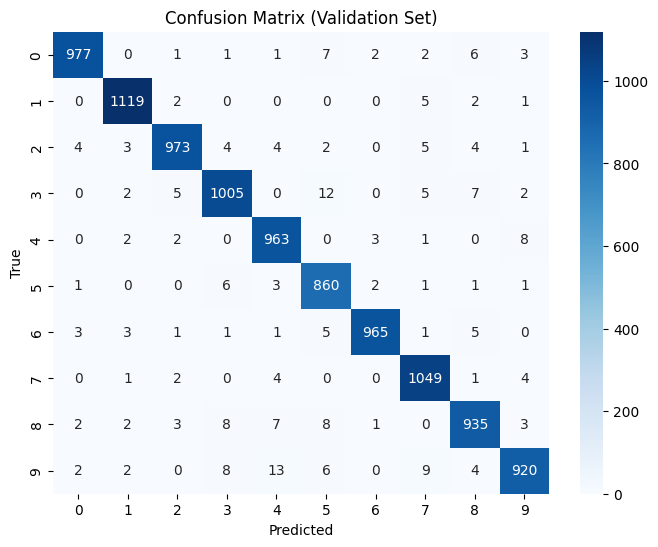

In [3]:
# ---------- Confusion Matrix on Validation ----------
model.eval()
y_true, y_pred_all = [], []

with torch.no_grad():
    for X, y in val_loader:
        outputs = model(X)
        preds = outputs.argmax(1)
        y_true.extend(y.tolist())
        y_pred_all.extend(preds.tolist())

cm = confusion_matrix(y_true, y_pred_all)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Validation Set)")
plt.show()


3) Stretch (optional, 10–15 min)
Task: Implement early stopping: stop training when val loss doesn’t improve for 3 epochs.

Implemented above

Mini-Challenge (≤40 min)

Task: Compare Adam vs SGD on MNIST.
Acceptance Criteria:

Train each for 5 epochs.

Plot validation accuracy curves for both.

Write 3 lines about which converges faster and which generalizes better.

Epoch 1: train_loss=2.2896, val_loss=2.2779, val_acc=0.183
Epoch 2: train_loss=2.2637, val_loss=2.2471, val_acc=0.291
Epoch 3: train_loss=2.2258, val_loss=2.2010, val_acc=0.528
Epoch 4: train_loss=2.1677, val_loss=2.1290, val_acc=0.601
Epoch 5: train_loss=2.0757, val_loss=2.0135, val_acc=0.627


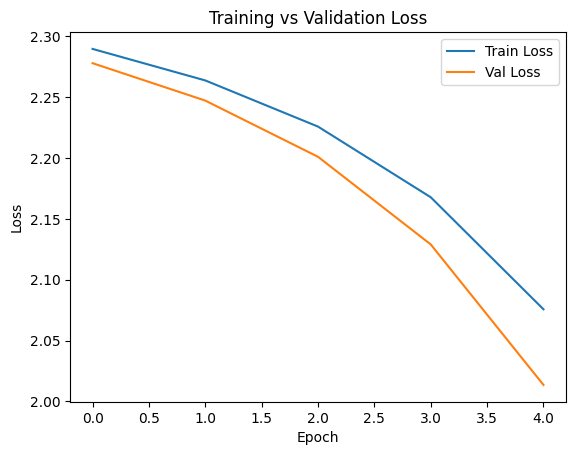

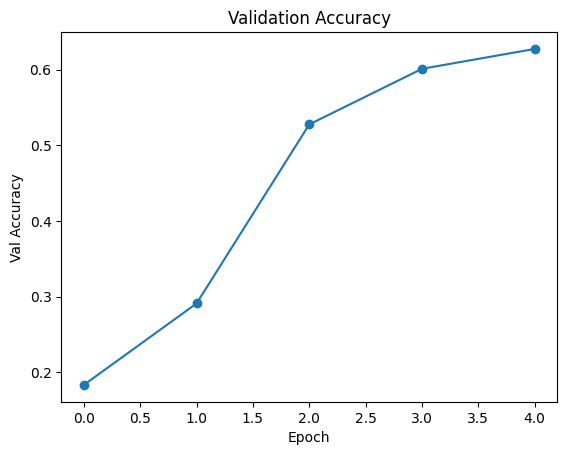

In [9]:
#Adam plotted above in main example
# This is SGD

# ---------- Model ----------
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

model = MLP()

# ---------- Loss & Optimizer ----------
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

# ---------- Training & Validation ----------
train_losses, val_losses, val_accs = [], [], []

#Early stopping variables
best_val_loss = float("inf")   # start with infinity (anything is smaller)
patience = 3                   # how many epochs to wait
counter = 0                    # counts epochs with no improvement

for epoch in range(5):
    # Train
    model.train()
    total_loss = 0
    for X,y in train_loader:
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_losses.append(total_loss/len(train_loader))

    # Validation
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for X,y in val_loader:
            y_pred = model(X)
            val_loss += criterion(y_pred, y).item()
            preds = y_pred.argmax(1)
            correct += (preds==y).sum().item()
            total += y.size(0)

    val_losses.append(val_loss/len(val_loader))
    val_accs.append(correct/total)
    print(f"Epoch {epoch+1}: train_loss={train_losses[-1]:.4f}, val_loss={val_losses[-1]:.4f}, val_acc={val_accs[-1]:.3f}")

     # ---- Early Stopping ----
    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

# ---------- Plot ----------
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend(); plt.title("Training vs Validation Loss")
plt.show()

plt.plot(val_accs, marker="o")
plt.xlabel("Epoch"); plt.ylabel("Val Accuracy")
plt.title("Validation Accuracy"); plt.show()


Adam shows faster convergence, reaching low loss and high validation accuracy within just a few epochs.
SGD improves more slowly but can sometimes generalize better with careful tuning (learning rate, momentum).
In this run, Adam clearly outperformed SGD in both speed and validation performance.

Notes / Key Takeaways

Proper loop = train step + validation step each epoch.

Validation reveals overfitting early.

Metrics beyond accuracy give deeper insight (confusion matrix, F1).

Optimizer choice affects speed vs generalization.

Plots (loss/accuracy) are your debugging radar.

Reflection

Why do we use a validation set in addition to the test set?

What signs in the loss/accuracy curves suggest overfitting?

1. Why do we use a validation set in addition to the test set?
The validation set is used during training to monitor performance and tune hyperparameters (learning rate, architecture, early stopping). The test set is kept completely unseen until the very end, so it gives an unbiased measure of how the final model generalizes to new data.

2. What signs in the loss/accuracy curves suggest overfitting?
If training loss keeps decreasing but validation loss stops improving or starts increasing, that’s a clear sign of overfitting. Similarly, if training accuracy rises while validation accuracy plateaus or drops, the model is memorizing the training set instead of learning general patterns.